(mapping-population)=
# Mapping Exposure - Population

## Summary
During a crisis, having accurate and up-to-date information about affected population is essential for providing an effective emergency response. Relying solely on country census information might not be feasible as in many cases the information might be outdated. Grided population estimates like the High Resolution Population Density Maps from Meta or Population Counts Estimates from WorldPop might come in handy to get up-to-date population distribution estimates. These datasets are created through models that combine different datasources like census data, satellite imagery, settlement data, terrain data, and others. 

This class will guide the students on how to obtain data from Meta and WorldPop to have an up-to-date estimate of total population at different geography levels. 

## Learning Objectives
### Overall goals
The main goal of this class is to teach students how to download and use alternative population data.

### Specific goals
At the end of this notebook, you should have gained an understanding and appreciation of the following:
1. **Meta's population dataset**:
   - Learn about Meta's population data.
   - How to download Meta's population data from HDX.
   - How to use Meta's population data for creating exposure maps.
2. **WorldPop population datset**:
   - Learn about WorldPop data.
   - How to use WorlPop's population data for creating exposure maps.

## Meta

In partnership with the Center for International Earth Science Information Network (CIESIN) at Columbia University, Meta uses state-of-the-art computer vision techniques to identify buildings from publicly accessible mapping services to create these population datasets. These maps are available at 30-meter resolution. Additionally, these datasets provide insights on the distribution of certain populations within each country, including the number of children under five, the number of women of reproductive age, as well as young and elderly populations, at unprecedentedly high resolutions. These maps aren’t built using Facebook data and instead rely on combining the power of machine vision AI with satellite imagery and census information. 
This data is publicly accessible on their [AWS Server](https://registry.opendata.aws/dataforgood-fb-hrsl/) or [HDX](https://data.humdata.org/organization/meta). Detailed documentation can be found [here](https://dataforgood.facebook.com/dfg/docs/methodology-high-resolution-population-density-maps).

### Access the data
The data is available in AWS and HDX. This course shows how to access it through HDX. 
The steps to get the data are:
1. Enter Meta page inside HDX with this [link](https://data.humdata.org/organization/meta).
2. In the search bar, type "High Resolution Population Density Maps + Demographic Estimates".
3. Search for the location you need to download data for. In this case, we are downloading the data for Türkiye.
```{figure} ../images/location_hdx.png
---
width: 600
name: location_hdx
---
Meta's available datasets at HDF.
``` 

4. There are several resources available for download. Pick the one of your interest. In this case, we are are downloading for 2020:
    - Men
    - Women
    - Women of reproductive age 15-49
    - Children under 5 for 2020
    - Eldery 60 plus for 2020
    - Youth 15-24
```{figure} ../images/results_hdx.png
---
width: 600
name: results_hdx
---
A resource might be comprised of several files.
``` 

### Analyze the data

In [1]:
# !pip install geopandas matplotlib seaborn

import pandas as pd
import geopandas as gpd
from shapely import Point
import os
import matplotlib.pyplot as plt
import seaborn as sns

#### Explore the data

In [2]:
path = '../../data/mapping-exposure-population/meta_hrp/'

In [3]:
data = pd.read_csv(path + 'tur_children_under_five_2020.csv')

In [4]:
data.head()

longitude   latitude  children_under_five_2020
0  27.235556  42.102222                  0.022541
1  27.265556  42.101944                  0.022541
2  27.265556  42.101667                  0.022541
3  27.275000  42.097500                  0.022541
4  34.945000  42.097222                  0.134411

In [5]:
def convert_to_gdf(df, lat_col, lon_col, crs = "EPSG:4326"):
    '''Take a dataframe that has latitude and longitude columns and tranform it into a geodataframe'''
    geometry = [Point(xy) for xy in zip(df[lon_col], df[lat_col])]
    gdf = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)
    return gdf

In [6]:
geo_data = convert_to_gdf(data, 'latitude', 'longitude', crs = "EPSG:4326")

In [7]:
# Explore a portion of the data.
# Filtering by latitude and longitude is faster than doing a spatial operation
geo_data[(geo_data['longitude']>28.93)&(geo_data['longitude']<28.98)&
         (geo_data['latitude']>41.00)&(geo_data['latitude']<41.02)].explore()

#### Create the maps
The goal of this section is to create maps using the high resolution population layer aggregated at the subnational administrative boundary level 2. For this, we use the administrative boundary we used in [Section 8.3.2](earthquake-overlay-admin2), when we studied earthquake intensity.  

In [8]:
adm2 = gpd.read_file('../../data/mapping-exposure-population/gadm41_TUR_2.json')
adm2.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [9]:
path = '../../data/mapping-exposure-population/meta_hrp/'
datasets = os.listdir(path)
datasets

['tur_women_of_reproductive_age_15_49_2020.csv',
 'tur_youth_15_24_2020.csv',
 'tur_men_2020.csv',
 'tur_elderly_60_plus_2020.csv',
 'tur_children_under_five_2020.csv',
 'tur_women_2020.csv']

In [ ]:
# Load datasets into a single dataframe to perform the spatial join only once
dfs = []
for d in datasets:
    data = pd.read_csv(path + d).set_index(['latitude', 'longitude'])
    dfs.append(data)
df = pd.concat(dfs, axis = 1)
df.reset_index(inplace = True)
df_gdf = convert_to_gdf(df, 'latitude', 'longitude', crs = "EPSG:4326")

In [ ]:
# Spatial join between the points and the administrative level 2
sjoin = gpd.sjoin(df_gdf, adm2, how = 'left')
# Aggregate the variables by administrative level 2
grp = sjoin.groupby(['GID_2', 'NAME_2', 'NAME_1'])[[x[4:-4] for x in datasets]].sum()

In [12]:
adm2.set_index(['GID_2', 'NAME_2', 'NAME_1'], inplace = True)

In [13]:
for col in grp.columns:
    adm2[col] = grp[col]

In [14]:
columns = grp.columns

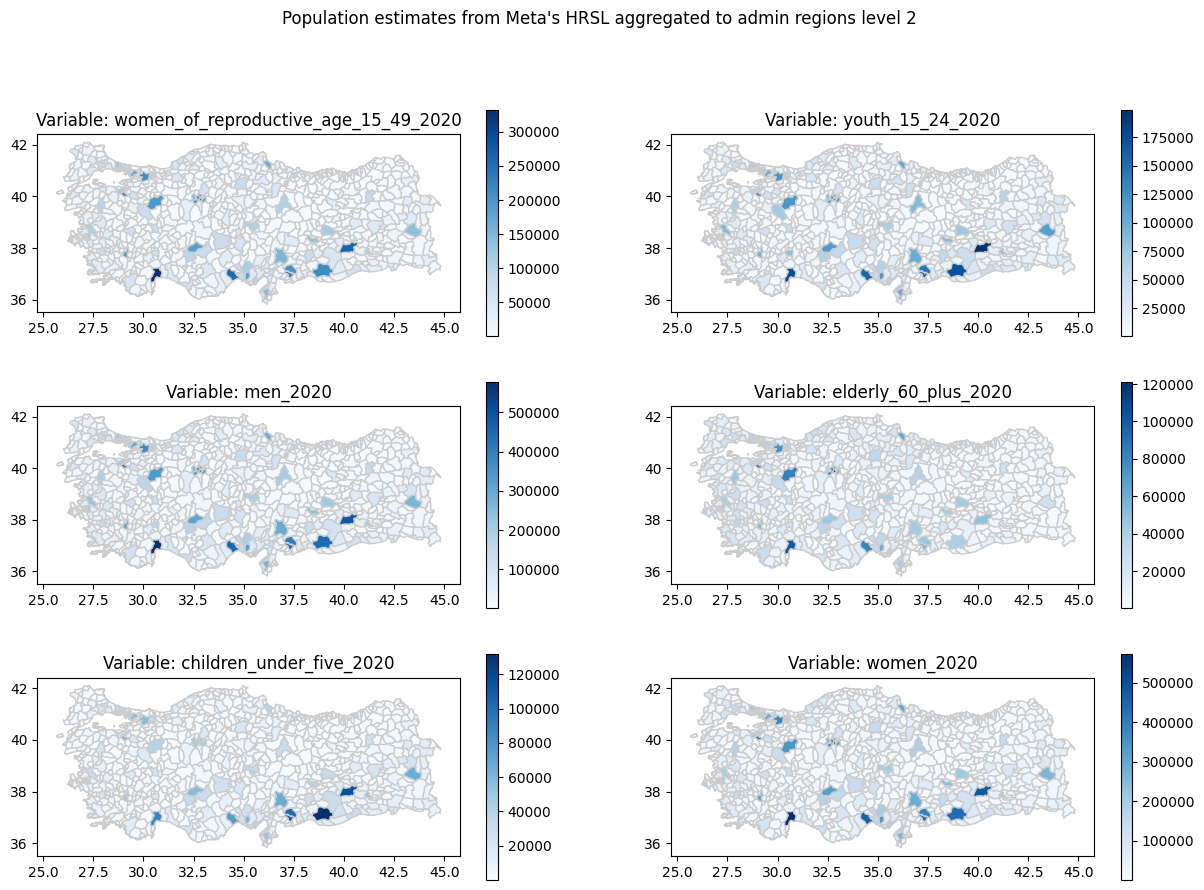

In [15]:
fig, axs = plt.subplots(3, 2, figsize = (15,10))
ax = axs.flatten()
fig.suptitle("Population estimates from Meta's HRSL aggregated to admin regions level 2")
for id, col in enumerate(grp.columns):
    adm2.plot(column = col, ax = ax[id], cmap = 'Blues', linewidth = 1, edgecolor='0.8', legend = True)
    ax[id].set_title('Variable: {}'.format(col))
plt.show()

## WorldPop

WorldPop is based at the University of Southampton and maps populations across the globe. Since 2013, they have partnered with governments, UN agencies, and donors to produce almost 45,000 datasets, complementing traditional population sources with dynamic, high-resolution data for mapping human population distributions, with the ultimate goal of ensuring that everyone, everywhere is counted in decision-making.

WorldPop produces different population estimates, you will need to read [this guide](https://www.worldpop.org/choosing-the-right-worldpop-population-data-for-you/) to find which estimate is the right fit for your project. 

## Access the data
The data can be accessed from their [website](https://www.worldpop.org/).

```{figure} ../images/worldpop.png
---
width: 600
name: worldpop
---
WorldPop's website.
``` 
There are several datasets available. In this example, we are downloading the population counts.

```{figure} ../images/datasets.png
---
width: 600
name: worldpop_datasets
---
WorldPop's datasets.
``` 

This example uses the "Constrained Individual countries 2020 (100m resolution)" dataset.  The constrained method uses extra layers that consider where settlements are placed. More information about the difference can be found [here](https://www.worldpop.org/methods/top_down_constrained_vs_unconstrained/).

### Analyze the data

In [ ]:
# !pip install rasterio rasterstats

import rasterio # Since the data is a geotiff
from rasterstats import zonal_stats
import matplotlib.pyplot as plt

In [24]:
dataset = rasterio.open('../../data/mapping-exposure-population/tur_ppp_2020_constrained.tif')

In [ ]:
band1 = dataset.read(1) # Rasters can have several bands. In this case, there is only one

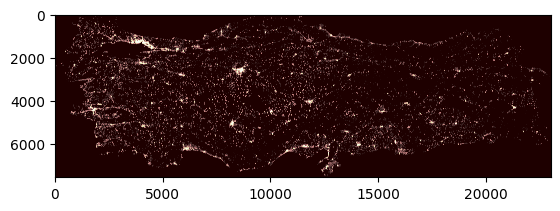

In [26]:
plt.imshow(band1, cmap='pink')

In [ ]:
# Aggregate the raster information to a administrative level 2 boundaries using rasterstats
raster_path = '../../data/mapping-exposure-population/tur_ppp_2020_constrained.tif'
stats = zonal_stats(adm2, raster_path, stats=['sum'])
adm2['population'] = pd.DataFrame(stats)['sum'].tolist()

In [ ]:
# Reproject adm2 to a projected CRS to calculate area
adm2 = adm2.to_crs('EPSG:32635')
adm2['area'] = adm2.geometry.apply(lambda x: x.area/1000000)
adm2['popdensity_km2'] = adm2['population']/adm2['area']

In [ ]:
m = adm2.explore(
    column="popdensity_km2",  # Make choropleth based on "POP2010" column
    scheme="naturalbreaks",  # Use mapclassify's natural breaks scheme
    legend=True,  # Show legend
    k=10,  # Use 10 bins
    tooltip=False,  # Hide tooltip
    popup=["population", 'popdensity_km2', 'area'],  # Show popup (on-click)
    legend_kwds=dict(colorbar=False),  # Do not use colorbar
    name="pop",  # Name of the layer in the map
)
m

## Practice

Using the presented datasources calculate population at administrative level 2 for Rio Grande do Sul State in Brasil. 

Compare the results obtained from the two datasources.